In [1]:
import datasets
from art.sourcesep_utils import measure_l1_for_source_separation, infer_and_save_results
from art.data.collate import create_sourceseparation_collate

%load_ext autoreload
%autoreload 2

In [2]:
label_noise = datasets.load_dataset(**{
    "path": "sebchw/sound_demixing_challenge",
    "name": "labelnoise",
    "zip_path": "sdxdb23_labelnoise_v1.0_rc1.zip",
  })

Found cached dataset sound_demixing_challenge (D:/hf_datasets/sebchw___sound_demixing_challenge/labelnoise-2279d988d676e56b/0.0.0/2eabcc8bf65bc3a2a2c2ba3f23993ebd542fc06824638c36acd791c073c64763)


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
label_noise["test"] = datasets.load_dataset("sebchw/musdb18", split="test")

Found cached dataset musdb18 (D:/hf_datasets/sebchw___musdb18/default/0.0.0/8e4f1e5b442f5b425fd98cffe0aa7001119aeaccf7d4bf07c49a70dc61cf6228)


In [5]:
label_noise

DatasetDict({
    train: Dataset({
        features: ['name', 'n_window', 'bass', 'drums', 'vocals', 'other', 'mean', 'std'],
        num_rows: 4453
    })
    test: Dataset({
        features: ['name', 'n_window', 'mixture', 'drums', 'bass', 'other', 'vocals', 'mean', 'std'],
        num_rows: 1273
    })
})

In [6]:
label_noise.save_to_disk("labelnoise", num_proc=-4)

Saving the dataset (0/63 shards):   0%|          | 0/4453 [00:00<?, ? examples/s]

Saving the dataset (0/23 shards):   0%|          | 0/1273 [00:00<?, ? examples/s]

In [7]:
ds2 = datasets.DatasetDict.load_from_disk("labelnoise")

In [8]:
ds2

DatasetDict({
    train: Dataset({
        features: ['name', 'n_window', 'bass', 'drums', 'vocals', 'other', 'mean', 'std'],
        num_rows: 4453
    })
    test: Dataset({
        features: ['name', 'n_window', 'mixture', 'drums', 'bass', 'other', 'vocals', 'mean', 'std'],
        num_rows: 1273
    })
})

In [2]:
dataset = datasets.load_dataset( "sebchw/sound_demixing_challenge", "labelnoise", zip_path= "sdxdb23_labelnoise_v1.0_rc1.zip",)

Found cached dataset sound_demixing_challenge (D:/hf_datasets/sebchw___sound_demixing_challenge/labelnoise-2279d988d676e56b/0.0.0/2eabcc8bf65bc3a2a2c2ba3f23993ebd542fc06824638c36acd791c073c64763)


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
dataset['test'] = musdb

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['name', 'n_window', 'bass', 'drums', 'vocals', 'other', 'mean', 'std'],
        num_rows: 4453
    })
    test: Dataset({
        features: ['name', 'n_window', 'mixture', 'drums', 'bass', 'other', 'vocals', 'mean', 'std'],
        num_rows: 1273
    })
})

In [3]:
dataset = dataset['train'].with_format("torch", device="cuda")

In [4]:
from art.litmodules import LitAudioSourceSeparator

params  = {"_target_" : "torchaudio.models.HDemucs",
  "sources": ["bass", "vocals", "drums", "other"]}
model = LitAudioSourceSeparator.load_from_checkpoint("sourceseparation-epoch=0-val_loss=0.24.ckpt", model=params)

c:\Users\sebas\mambaforge\envs\data-science\lib\site-packages\neptune\common\warnings.py:62: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  warnings.warn(
c:\Users\sebas\mambaforge\envs\data-science\lib\site-packages\neptune\common\warnings.py:62: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  warnings.warn(
c:\Users\sebas\mambaforge\envs\data-science\lib\site-packages\lightning\pytorch\utilities\migration\utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.1, which is newer than your current Lightning version: v2.0.0
  rank_zero_warn(


In [5]:
model = model.to("cuda")

In [6]:
LENGTH = 441000
INSTRUMENTS = model.model.sources
COLLATE_FUNCTION = create_sourceseparation_collate(LENGTH, INSTRUMENTS)

In [7]:
dataset_l1 = measure_l1_for_source_separation(dataset, model, create_sourceseparation_collate(instruments=model.sources))

Map:   0%|          | 0/4452 [00:00<?, ? examples/s]

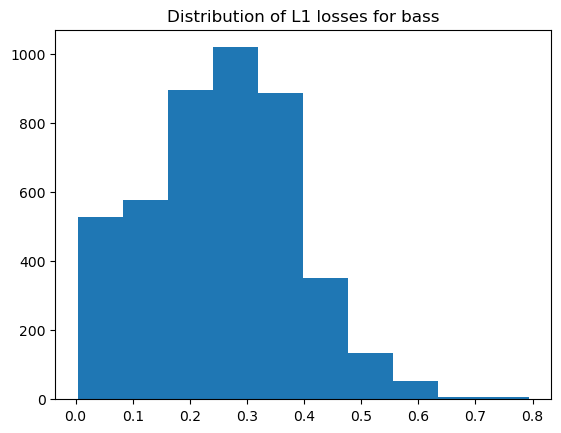

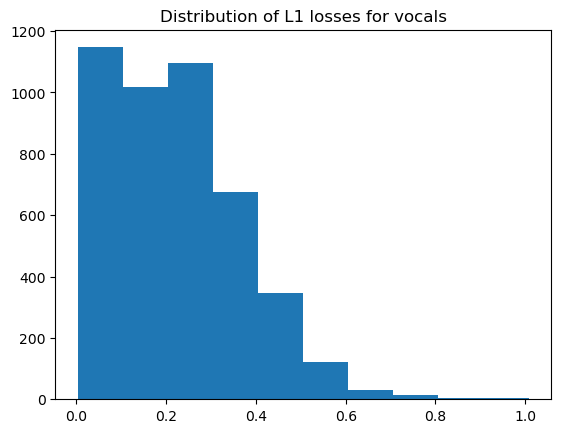

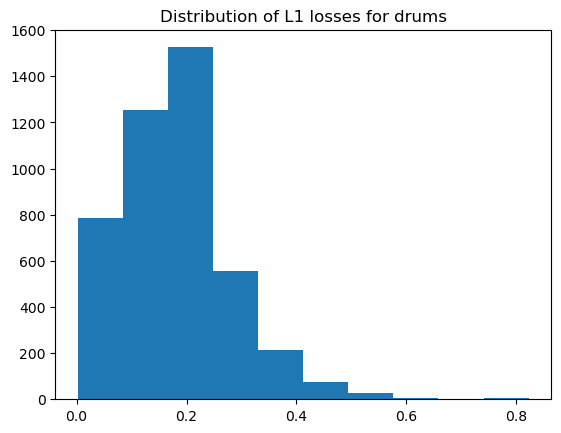

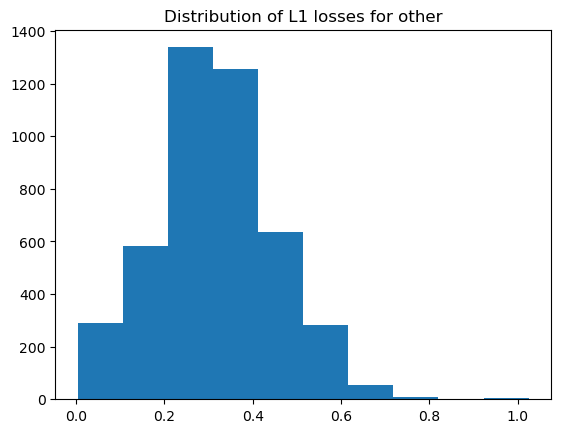

In [8]:
import matplotlib.pyplot as plt

for instrument in model.sources:
    plt.hist(dataset_l1[f"{instrument}L1"].cpu())
    plt.title(f"Distribution of L1 losses for {instrument}")
    plt.show()

In [19]:
dataset_outliers = dataset_l1.filter(lambda example: example['vocalsL1'] > 0.6)

Loading cached processed dataset at D:\hf_datasets\sebchw___sound_demixing_challenge\labelnoise-2279d988d676e56b\0.0.0\2eabcc8bf65bc3a2a2c2ba3f23993ebd542fc06824638c36acd791c073c64763\cache-71b10d77c27a5486.arrow


In [20]:
import numpy as np
np.unique(dataset_outliers['name'], return_counts=True)

(array(['labelnoise/05b0ab77-2495-438d-8831-e3d81f96c16d',
        'labelnoise/0a589d65-50a3-4999-8f16-b5b6199bceee',
        'labelnoise/13f233aa-a2e5-4683-8533-2f1e344b55b4',
        'labelnoise/1f98fe4d-26c7-460f-9f68-33964bc4d8d3',
        'labelnoise/1fc37390-1769-452d-9bea-19025be4c467',
        'labelnoise/312bec8d-1c61-43e0-924a-1fb87ddc3e41',
        'labelnoise/322f4d9d-b0c9-4ab3-9e30-544a25331ffd',
        'labelnoise/36ee7fc6-604c-4a75-b4f0-0a9ceef3b9cb',
        'labelnoise/3e656eec-84d4-4a45-b410-d3817d849f92',
        'labelnoise/4cbd6c36-87a2-4d50-86e3-52d39b98fad3',
        'labelnoise/5f04798d-c7be-4b8a-90bd-1fcd9946e875',
        'labelnoise/7bfa233c-24ed-4c7a-9096-11e3aa00c55d',
        'labelnoise/a0eae9d2-d97f-401a-a495-1e1d1cb84a9c',
        'labelnoise/cc7f7675-d3c8-4a49-a2d7-a8959b694004',
        'labelnoise/d2401d3d-967c-46be-b9a0-3da571105158',
        'labelnoise/d4df499c-e394-4753-b459-e167e6a58bad',
        'labelnoise/d890ff35-300d-49f2-8054-49ab47262987

In [25]:
dataset_outliers[0:10]

{'name': ['labelnoise/312bec8d-1c61-43e0-924a-1fb87ddc3e41',
  'labelnoise/312bec8d-1c61-43e0-924a-1fb87ddc3e41',
  'labelnoise/7bfa233c-24ed-4c7a-9096-11e3aa00c55d',
  'labelnoise/7bfa233c-24ed-4c7a-9096-11e3aa00c55d',
  'labelnoise/5f04798d-c7be-4b8a-90bd-1fcd9946e875',
  'labelnoise/d890ff35-300d-49f2-8054-49ab47262987',
  'labelnoise/d890ff35-300d-49f2-8054-49ab47262987',
  'labelnoise/d890ff35-300d-49f2-8054-49ab47262987',
  'labelnoise/d890ff35-300d-49f2-8054-49ab47262987',
  'labelnoise/3e656eec-84d4-4a45-b410-d3817d849f92'],
 'n_window': tensor([15, 18, 13, 26, 17, 21, 22, 23, 24, 19], device='cuda:0'),
 'mean': tensor([ 2.7085e-04,  2.7085e-04, -1.3096e-04, -1.3096e-04, -2.2714e-04,
         -6.1662e-05, -6.1662e-05, -6.1662e-05, -6.1662e-05, -1.8111e-04],
        device='cuda:0'),
 'std': tensor([0.0625, 0.0625, 0.0691, 0.0691, 0.1092, 0.0429, 0.0429, 0.0429, 0.0429,
         0.0657], device='cuda:0'),
 'bassL1': tensor([0.3384, 0.4107, 0.3726, 0.2683, 0.0948, 0.3208, 0.4078,

In [45]:
infer_and_save_results(dataset.select([98]), model)

In [ ]:
from torchaudio.models import HDemucs

In [41]:
from torchaudio.pipelines import HDEMUCS_HIGH_MUSDB_PLUS

In [44]:
bundle = HDEMUCS_HIGH_MUSDB_PLUS
model2 = bundle.get_model()
model2.to("cuda")

infer_and_save_results(dataset.select([98]), model2)